<a href="https://colab.research.google.com/github/sonG1031/ML_DL_STUDY/blob/main/%ED%95%A9%EC%84%B1%EA%B3%B1%EC%8B%A0%EA%B2%BD%EB%A7%9D_%EC%8B%A4%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

합성곱 신경망은 2차원 이미지를 그대로 사용하기 때문에 데이터를 일렬로 펼치지 않아도 됨.  
그러나 입력 이미지는 항상 깊이(채널) 차원이 있어야한다. 따라서 Conv2D를 사용하기 위해  
마지막에 이 채널 차원을 추가해야 한다.

In [1]:
# 데이터 준비
from tensorflow import keras
from sklearn.model_selection import train_test_split

(train_input, train_target), (test_input, test_target) =\
    keras.datasets.fashion_mnist.load_data()
train_scaled = train_input.reshape(-1, 28, 28, 1) / 255.0
train_scaled, val_scaled, train_target, val_target =\
    train_test_split(train_scaled, train_target, test_size=0.2, random_state=42)

4422102/4422102 [==============================] - 0s 0us/step


In [4]:
print(train_scaled.shape)

(48000, 28, 28, 1)


합성곱 신경망의 구조는 합성곱 층으로 이미지에서 특징을 감지한 후 밀집층으로 클래스에 따른 분류 확률을 계산한다.

### 첫 번째 합성곱-풀링 층

In [5]:
model = keras.Sequential()
#1 합성곱 층
model.add(keras.layers.Conv2D(32, kernel_size=3, activation='relu', padding='same', input_shape=(28,28,1)))

위 합성곱 층은 32개의 필터를 사용하고, 커널의 크기는 (3,3), 렐루 활성화 함수, 세임 패딩을 사용한다.  
특성 맵의 크기 : (28, 28, 32)

In [6]:
#2 풀링 층
model.add(keras.layers.MaxPooling2D(2))

특성 맵의 크기 : (14,14,32)

### 두 번째 합성곱-풀링 층

첫 번째와 거의 동일하나 필터의 개수를 64개로 늘린 점이 다르다.

In [7]:
model.add(keras.layers.Conv2D(64, kernel_size=3, activation='relu', padding='same'))
model.add(keras.layers.MaxPooling2D(2))

특성 맵의 크기 : (7,7,64)

### 이제 이 3차원 특성 맵을 일렬로 펼칠 차례

이렇게 하는 이유는 마지막에 10개의 뉴런을 가진 (밀집) 출력층에서 확률을 계산하기 때문.  
여기에서는 특성 맵을 일렬로 펼쳐서 바로 출력층에 전달하지 않고 중간에 하나의 밀집 은닉층을 더 넣었다.

In [8]:
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(100, activation='relu')) # 은닉층
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(10, activation='softmax')) # 출력층

은닉층과 출력층 사이에 드롭아웃을 넣었다.  
드롭아웃 층이 은닉층의 과대적합을 막아 성능을 조금 더 개선해 줄 것이다.

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 100)               3

케라스는 summary() 메서드 외에 층의 구성을 그림으로 표현해주는 plot_model() 함수를   
keras.utils 패키지에서 제공한다.

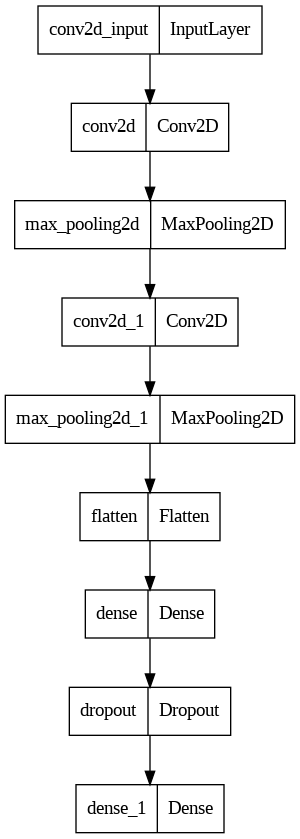

In [10]:
keras.utils.plot_model(model)

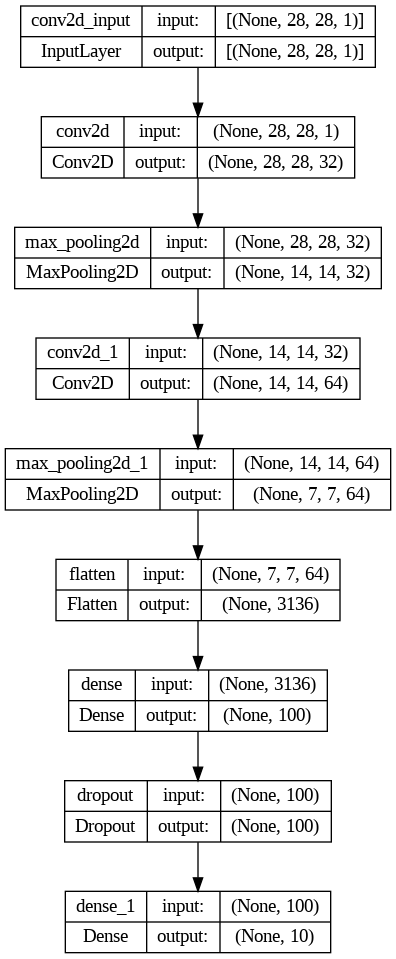

In [11]:
keras.utils.plot_model(model, show_shapes=True)

### 모델 컴파일과 훈련

케라스 API의 장점은 딥러닝 모델의 종류나 구성 방식에 상관없이 컴파일과 훈련 과정이 같다는 점

Adam 옵티마이저(적응적 학습률 + Momentum)를 사용하고 ModelCheckpoint, EarlyStopping 콜백을 사용하여 조기 종료 기법을 구현한다.

In [12]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-cnn-model.h5', save_best_only=True)

history = model.fit(train_scaled, train_target, epochs=20, validation_data=(val_scaled, val_target), callbacks=[checkpoint_cb, early_stopping_cb])


Epoch 1/20
1500/1500 [==============================] - 17s 4ms/step - loss: 0.5411 - accuracy: 0.8069 - val_loss: 0.3558 - val_accuracy: 0.8692
Epoch 2/20
1500/1500 [==============================] - 6s 4ms/step - loss: 0.3597 - accuracy: 0.8722 - val_loss: 0.2908 - val_accuracy: 0.8909
Epoch 3/20
1500/1500 [==============================] - 6s 4ms/step - loss: 0.3088 - accuracy: 0.8884 - val_loss: 0.2578 - val_accuracy: 0.9043
Epoch 4/20
1500/1500 [==============================] - 7s 4ms/step - loss: 0.2756 - accuracy: 0.8992 - val_loss: 0.2456 - val_accuracy: 0.9083
Epoch 5/20
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2528 - accuracy: 0.9078 - val_loss: 0.2535 - val_accuracy: 0.9072
Epoch 6/20
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2310 - accuracy: 0.9142 - val_loss: 0.2264 - val_accuracy: 0.9138
Epoch 7/20
1500/1500 [==============================] - 8s 5ms/step - loss: 0.2131 - accuracy: 0.9208 - val_loss: 0.2300 - val_accuracy

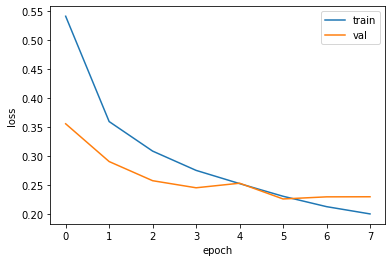

In [13]:
# 손실 그래프 
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

In [14]:
# 검증 세트 평가
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 2ms/step - loss: 0.2264 - accuracy: 0.9138


[0.22635453939437866, 0.9138333201408386]

predict() 메서드를 사용해 훈련된 모델을 사용하여 새로운 데이터에 대해 예측을 만들어보자

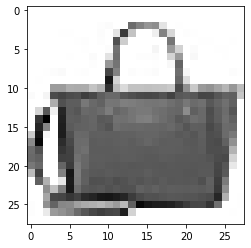

In [15]:
plt.imshow(val_scaled[0].reshape(28,28), cmap='gray_r')
plt.show()

In [16]:
preds = model.predict(val_scaled[:1])
print(preds)

1/1 [==============================] - 0s 349ms/step
[[8.4539869e-18 6.1771311e-23 1.6335009e-17 1.4919783e-18 3.5364704e-17
  1.0579606e-15 5.2577633e-16 2.1967805e-19 1.0000000e+00 4.9437468e-19]]


슬라이싱을 사용한 이유는 케라스의 fit(), predict(), evaluate() 메서드는 모두 입력의 첫번째 차원이 배치 차원일 것으로 기대하기 때문.  
따라서 샘플 하나를 전달할 때 (28,28,1)이 아니라 (1,28,28,1) 크기를 전달해야함.

출력 결과를 보면 아홉 번째 값이 1이고 다른 값은 거의 0에 가깝다.  
다시 말해 아홉 번째 클래스라고 강하게 주장하고 있는 것이다.  
막대 그래프를 통해 확실하게 느낄 수 있다.

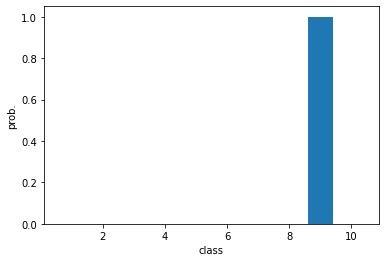

In [17]:
plt.bar(range(1,11), preds[0])
plt.xlabel('class')
plt.ylabel('prob.')
plt.show()

In [18]:
# 패션 MNIST 데이터셋의 레이블 리스트

classes = ['티셔츠', '바지', '스웨터', '드레스', '코트', '샌달', '셔츠', '스니커즈', '가방', '앵클 부츠']

In [19]:
import numpy as np
print(classes[np.argmax(preds)])

가방


### 마지막으로 테스트 세트를 통해 일반화 성능을 확인하기

In [20]:
test_scaled = test_input.reshape(-1, 28, 28, 1) / 255.0
model.evaluate(test_scaled, test_target)

313/313 [==============================] - 1s 3ms/step - loss: 0.2464 - accuracy: 0.9078


[0.24641428887844086, 0.907800018787384]